# AC209B - MS2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import cv2
import sys
import random
import seaborn as sns
import missingno as msno

sys.path.insert(0, '../')
from DeepFill.run_preprocessing import deep_fill

from src.data_preprocessing import preprocess

from sklearn.impute import KNNImputer, SimpleImputer

In [1]:
import torch

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


## Dataset Description

This dataset, sourced from the UCI ML Repository and originally collected at Children’s Hospital St. Hedwig (2016–2021), contains two components:

1. Tabular data: 782 pediatric cases with 53 clinical features (lab results, symptoms, scores, ultrasound findings) and three target variables (diagnosis, severity, management).

2. Image data: 1709 ultrasound images (B-mode, multiview), with 1–15 views per patient. The primary task is to classify diagnosis (appendicitis vs. no) and offer visually interpretable insights. 

## Tabular Data Loading

### Load

In [2]:
# Load tabular data
app_data = pd.read_csv("../data/app_data.csv")
app_data.shape

(782, 58)

In [3]:
# Data size
def get_file_size(path='.'):
    total = os.path.getsize(path)
    return total / (1024 * 1024)

print(f"Total dataset size: {get_file_size('../data/app_data.csv'):.2f} MB")

Total dataset size: 0.18 MB


In [4]:
# Inspect data
app_data.head()
len(app_data.columns)

58

In [5]:
# Keep important variables
target_variables = ["Diagnosis", "Severity", "Management"]
# y = app_data[target_variables] #dataframe


feature_variables = ['Age', 'Sex', 'BMI',  # Can influence disease course and treatment decisions
    'Coughing_Pain', 'Psoas_Sign', 'Contralateral_Rebound_Tenderness',  # Physical signs
    'Dysuria', 'Stool',  # May help with differential diagnosis
    'Ketones_in_Urine', 'WBC_in_Urine', 'RBC_in_Urine',  # UTI or confounders
    'Meteorism', 'Enteritis',  # Alternatives to appendicitis
    'Gynecological_Findings',  # Important in adolescent females 
    'Alvarado_Score', 'Paedriatic_Appendicitis_Score', # Scoring Systems
    'Lower_Right_Abd_Pain', 'Migratory_Pain', 'Loss_of_Appetite', 'Nausea', # Key Clinical Signs/Symptoms
    'Peritonitis', 'Body_Temperature',
    'WBC_Count', 'Neutrophil_Percentage', 'CRP', # Lab Values
    'Appendix_on_US', 'Appendix_Diameter', 'Free_Fluids', # Ultrasound Findings
    'Appendix_Wall_Layers', 'Target_Sign',
    'Surrounding_Tissue_Reaction', 
    'Perforation',                # Signals complicated appendicitis → surgery
    'Appendicular_Abscess',       # May lead to conservative mgmt or delayed surgery
    'Perfusion',                  # Reduced perfusion = necrosis = surgery
    'Ileus',                      # Complicated or late-stage
    'Pathological_Lymph_Nodes',   # Possible misdiagnosis or associated findings
    'Bowel_Wall_Thickening',      # Differential diagnosis
    'Coprostasis',                # May contribute to obstruction
    'Conglomerate_of_Bowel_Loops', # Suggestive of post-inflammatory changes
                    ]
# x = app_data[feature_variables]

patient_codes_tab = app_data['US_Number']

In our preprocessing, we identified and dropped a number of variables from the original dataset that were either redundant, not informative for modeling, or not relevant to our task:

- Height, Weight, and Length_of_Stay were removed as they do not directly contribute to diagnostic prediction and are not clinically relevant for real-time assessment.

- Diagnosis_Presumptive was excluded to avoid potential data leakage, as it may reflect clinical suspicions closely tied to the final outcome.

- Segmented_Neutrophils, Neutrophilia, and RBC_Count were dropped as their information is already captured in existing features such as WBC_Count, Neutrophil_Percentage, and other lab markers.

- Hemoglobin, RDW, and Thrombocyte_Count were excluded due to their limited diagnostic value for appendicitis in this context.

- Ipsilateral_Rebound_Tenderness was removed due to redundancy with Contralateral_Rebound_Tenderness and overlapping clinical interpretation.

- US_Performed because we match patients with images performed based on their user id below.

- Appendicolith, Abscess_Location, and Lymph_Nodes_Location were dropped due to their free-text nature or lack of standard formatting, which makes consistent interpretation or encoding difficult at this stage. Additionally, these overlap with other binary indicators already included (e.g., Appendicular_Abscess, Pathological_Lymph_Nodes).


### Missing Data

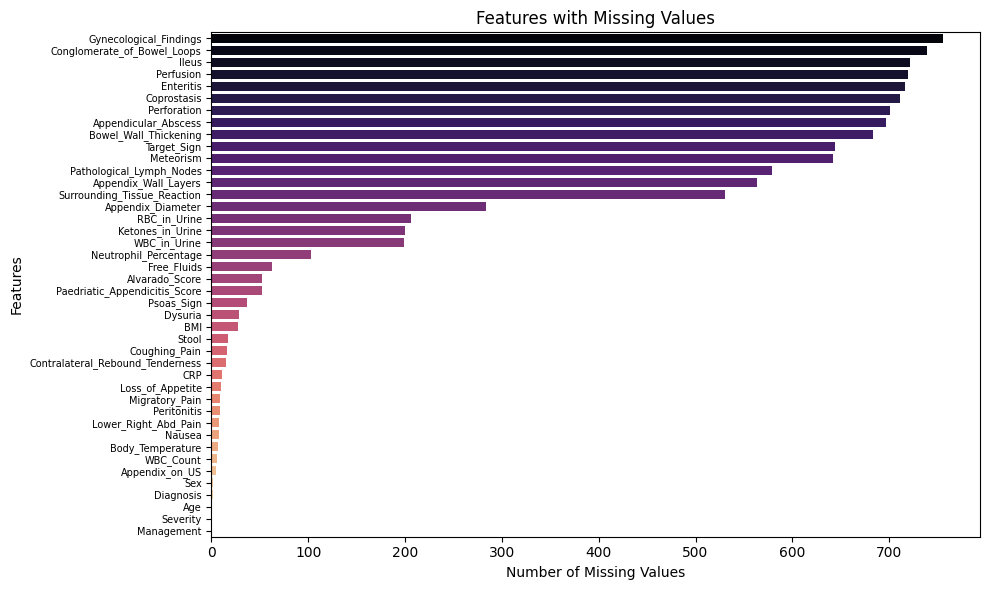

In [6]:
missing_counts = app_data[feature_variables + target_variables].isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_counts.values, y=missing_counts.index, hue=missing_counts.index, 
            dodge=False, palette="magma", legend=False)
plt.title("Features with Missing Values")
plt.xlabel("Number of Missing Values")
plt.ylabel("Features")
plt.tick_params(axis='y', labelsize=7)
plt.tight_layout()

In [7]:
missing_percent = app_data[feature_variables + target_variables].isnull().mean() * 100
missing_summary = pd.DataFrame({
    'Missing Count': app_data[feature_variables + target_variables].isnull().sum(),
    'Missing %': missing_percent
})

# Filter and sort in descending order
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
missing_summary = missing_summary.sort_values(by='Missing Count', ascending=False)

print(missing_summary)

                                  Missing Count  Missing %
Gynecological_Findings                      756  96.675192
Conglomerate_of_Bowel_Loops                 739  94.501279
Ileus                                       722  92.327366
Perfusion                                   719  91.943734
Enteritis                                   716  91.560102
Coprostasis                                 711  90.920716
Perforation                                 701  89.641944
Appendicular_Abscess                        697  89.130435
Bowel_Wall_Thickening                       683  87.340153
Target_Sign                                 644  82.352941
Meteorism                                   642  82.097187
Pathological_Lymph_Nodes                    579  74.040921
Appendix_Wall_Layers                        564  72.122762
Surrounding_Tissue_Reaction                 530  67.774936
Appendix_Diameter                           284  36.317136
RBC_in_Urine                                206  26.3427

In [8]:
features_to_keep = missing_counts[missing_counts < 300].index.tolist()

print("Keeping these features:", features_to_keep)

Keeping these features: ['Appendix_Diameter', 'RBC_in_Urine', 'Ketones_in_Urine', 'WBC_in_Urine', 'Neutrophil_Percentage', 'Free_Fluids', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Psoas_Sign', 'Dysuria', 'BMI', 'Stool', 'Coughing_Pain', 'Contralateral_Rebound_Tenderness', 'CRP', 'Loss_of_Appetite', 'Migratory_Pain', 'Peritonitis', 'Lower_Right_Abd_Pain', 'Nausea', 'Body_Temperature', 'WBC_Count', 'Appendix_on_US', 'Sex', 'Diagnosis', 'Age', 'Severity', 'Management']


In [9]:
app_data_clean=app_data[features_to_keep]

To ensure data quality and minimize bias, we retained only features with less than 50% missing values, starting from "Appendix Diameter" downward in the missing values plot. Features above this threshold contain too much missing data to be reliably imputed or used in analysis, which could lead to distorted results and reduce model robustness. By focusing on variables with more complete data, we preserve statistical validity while maintaining meaningful information for downstream tasks.



In [10]:
# Define variable categories 
numerical_vars = ['Neutrophil_Percentage', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score',
                  'BMI', 'CRP', 'Body_Temperature', 'WBC_Count', 'Age']

categorical_vars = ['RBC_in_Urine', # negative, +, ++, +++
                    'Ketones_in_Urine', # no, +, ++, +++
                    'WBC_in_Urine', # no, +, ++, +++
                    'Stool', # normal, diarrhea, obstipation
                    'Peritonitis' # no, localised, generalised
                   ]

binary_vars = ['Sex', 'Coughing_Pain', 'Psoas_Sign', 'Contralateral_Rebound_Tenderness', 'Free_Fluids',
               'Dysuria', 'Loss_of_Appetite', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Nausea']

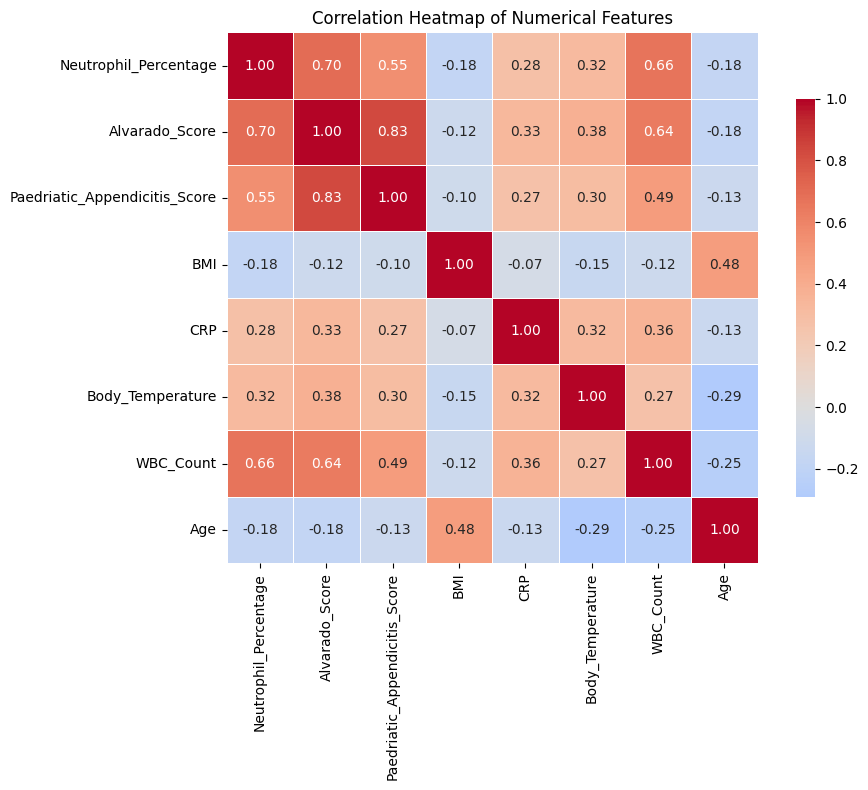

In [11]:
# Calculate correlation matrix
corr_matrix = app_data[numerical_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .75})

plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()

In [12]:
data = {
    'Variable': [
        'Appendix_Diameter', 'RBC_in_Urine', 'Ketones_in_Urine', 'WBC_in_Urine',
        'Neutrophil_Percentage', 'Free_Fluids', 'Alvarado_Score',
        'Paediatric_Appendicitis_Score', 'Psoas_Sign', 'Dysuria', 'BMI', 'Stool',
        'Coughing_Pain', 'Contralateral_Rebound_Tenderness', 'CRP', 'Loss_of_Appetite',
        'Migratory_Pain', 'Peritonitis', 'Lower_Right_Abd_Pain', 'Nausea', 'Body_Temperature',
        'WBC_Count', 'Appendix_on_US', 'Sex', 'Diagnosis', 'Severity', 'Management', 'Age'
    ],
    'Type': [
        'Numeric', 'Categorical', 'Categorical', 'Categorical', 'Numeric', 'Binary',
        'Numeric', 'Numeric', 'Binary', 'Binary', 'Numeric', 'Categorical', 'Binary',
        'Binary', 'Numeric', 'Binary', 'Binary', 'Categorical', 'Binary', 'Binary',
        'Numeric', 'Numeric', 'Binary', 'Binary', 'Categorical (target)', 'Categorical (target)',
        'Categorical (target)', 'Numeric'
    ],
    'Likely Missingness': [
        'MNAR (only measured if visible)', 'MAR', 'MAR', 'MAR', 'MCAR or MAR', 'MAR or MNAR',
        'MCAR or MAR', 'MCAR or MAR', 'MCAR or MAR', 'MAR', 'MCAR or MAR', 'MAR',
        'MCAR', 'MCAR', 'MCAR', 'MCAR', 'MCAR', 'MCAR', 'MCAR', 'MCAR',
        'MCAR', 'MCAR', 'MNAR', 'MCAR', 'Very low missing', 'Very low missing',
        'Very low missing', 'MCAR'
    ],
    'Suggested Imputation Method': [
        "Add missingness flag", 'KNN', 'KNN',
        'KNN', 'KNN', 'Mode imputation and add missing flag',
        'KNN', 'KNN', 'Mode imputation', 'Mode imputation',
        'Median imputation', 'Mode imputation', 'Mode imputation', 'Mode imputation',
        'Median imputation', 'Mode imputation', 'Mode imputation', 'Mode imputation',
        'Mode imputation', 'Mode imputation', 'Median imputation', 'KNN',
        "Add missing flag", 'Mode imputation',
        'Drop missing rows', 'Drop missing rows', 'Drop missing rows', 'Median imputation'
    ]
}
df = pd.DataFrame(data)
# Show with basic styling
df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([
    {"selector": "th", "props": [("text-align", "left")]}
])

,Variable,Type,Likely Missingness,Suggested Imputation Method
0,Appendix_Diameter,Numeric,MNAR (only measured if visible),Add missingness flag
1,RBC_in_Urine,Categorical,MAR,KNN
2,Ketones_in_Urine,Categorical,MAR,KNN
3,WBC_in_Urine,Categorical,MAR,KNN
4,Neutrophil_Percentage,Numeric,MCAR or MAR,KNN
5,Free_Fluids,Binary,MAR or MNAR,Mode imputation and add missing flag
6,Alvarado_Score,Numeric,MCAR or MAR,KNN
7,Paediatric_Appendicitis_Score,Numeric,MCAR or MAR,KNN
8,Psoas_Sign,Binary,MCAR or MAR,Mode imputation
9,Dysuria,Binary,MAR,Mode imputation


To address missing data in our dataset, we applied different imputation strategies tailored to the nature of each variable and the likely cause of its missingness, as summarized in the table above. The approach was guided by both statistical patterns and domain context, aiming to balance data integrity with practical feasibility.

1. Dropping Missing Row

    For the target variables with extremely low rates of missingness (1 observation), we opted to drop the corresponding row entirely. This is a single case and dropping it does not significantly reduce the dataset size. Moreover, imputing missing target labels risks compromising model training or evaluation, so removal is the more appropriate and cleaner solution.

2. Missingness Flag 

    For features where missingness itself is likely informative, such as measurements that are only recorded under specific clinical conditions,  we avoided only direct imputation. For instance, appendix diameter is only measured if visible. Instead, we added a binary flag to indicate the presence or absence of the value. This preserves potential signals related to the decision to measure or observe the variable in the first place, which may carry diagnostic relevance. This approach is especially important for features influenced by clinical judgment or selective measurement procedures.

3. KNN Imputation

    K-nearest neighbors (KNN) imputation was applied to several numeric and categorical variables where missingness is likely dependent on other observed values. These variables exhibit strong correlations with other features, making KNN a suitable method to preserve the structure and contextual relationships within the data. KNN considers the values of similar observations (nearest neighbors) to estimate missing entries, which is particularly valuable for medical variables where related symptoms or measurements tend to occur together. This approach avoids oversimplifying patterns that would be lost with more simple methods like mean or mode imputation.

4. Median and Mode Imputation

    For variables with weak or no strong correlations, or where missingness appears to be more arbitrary or completely at random, we used median imputation for numeric variables and mode imputation for binary or categorical ones. These methods are simple, computationally efficient, and reduce the risk of introducing artificial patterns. They were primarily chosen when the goal was to preserve the general distribution of the data without adding unnecessary complexity, particularly for features where the majority class or central tendency dominates.


In [13]:
# Separate variables based on type and imputation method
knn_numeric = ['Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'WBC_Count', 'Neutrophil_Percentage']
knn_categorical = ['RBC_in_Urine', 'Ketones_in_Urine', 'WBC_in_Urine']
median_numeric = ['BMI', 'CRP', 'Body_Temperature', 'Age']
mode_cat_bin = ['Psoas_Sign', 'Dysuria', 'Stool', 'Coughing_Pain',
    'Contralateral_Rebound_Tenderness', 'Loss_of_Appetite',
    'Migratory_Pain', 'Peritonitis', 'Lower_Right_Abd_Pain',
    'Nausea', 'Sex', 'Free_Fluids' 
]
mnar_vars = ['Appendix_Diameter', 'Appendix_on_US', 'Free_Fluids']

In [14]:
# Drop row with missing target variables
app_data_clean = app_data_clean.dropna(subset=['Diagnosis', 'Severity', 'Management'])

In [15]:
# Add missingness flags for MNAR data
for col in mnar_vars:
    app_data_clean[f"{col}_missing"] = app_data_clean[col].isnull().astype(int)

In [16]:
# Numeric + Correlated + MAR → KNN
knn_imputer_num = KNNImputer(n_neighbors=5)
app_data_clean[knn_numeric] = knn_imputer_num.fit_transform(app_data_clean[knn_numeric])
app_data_clean[knn_numeric] = app_data_clean[knn_numeric].round(2)

# Categorical + MAR → KNN
app_data_clean_encoded = app_data.copy()
cat_encoding_maps = {}

# Encode categories
for col in knn_categorical:
    unique_vals = app_data_clean[col].dropna().unique().tolist()
    encoding = {val: idx for idx, val in enumerate(unique_vals)}
    cat_encoding_maps[col] = encoding
    app_data_clean_encoded[col] = app_data_clean[col].map(encoding)

# Apply KNN imputation on encoded data
knn_imputer_cat = KNNImputer(n_neighbors=5)
app_data_clean_encoded[knn_categorical] = knn_imputer_cat.fit_transform(app_data_clean_encoded[knn_categorical])

# Decode categories back to original labels
for col in knn_categorical:
    reverse_map = {v: k for k, v in cat_encoding_maps[col].items()}
    app_data_clean[col] = app_data_clean_encoded[col].round().astype(int).map(reverse_map)


# Numeric → Median
median_imputer = SimpleImputer(strategy='median')
app_data_clean[median_numeric] = median_imputer.fit_transform(app_data_clean[median_numeric])
app_data_clean[median_numeric] = app_data_clean[median_numeric].round(2)

# Categorical + Binary → Mode
mode_imputer = SimpleImputer(strategy='most_frequent')
app_data_clean[mode_cat_bin] = mode_imputer.fit_transform(app_data_clean[mode_cat_bin])

In [17]:
app_data_clean.to_csv("../data/app_data_clean.csv", index=False)

## Image Data Loading

### Load 

In [7]:
image_file_list = glob.glob("../data/US_Pictures/*")
image_names = []
patient_codes_im = []
for file in image_file_list:
    name = file.split('/')[-1]
    patient_code = re.split('_| |\.', name)[0]
    image_names.append(name)
    patient_codes_im.append(patient_code)
groups = np.array(list(map(int, patient_codes_im)))
print("Total number of patients having US images: ", len(np.unique(patient_codes_im)))
print("Total number of images: ", len(image_file_list))

Total number of patients having US images:  707
Total number of images:  2097


In [8]:
# Data size
def get_dir_size(path='.'):
    total = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total += os.path.getsize(fp)
    return total / (1024 * 1024)

print(f"Total dataset size: {get_dir_size('../data/US_Pictures'):.2f} MB")

Total dataset size: 2450.81 MB


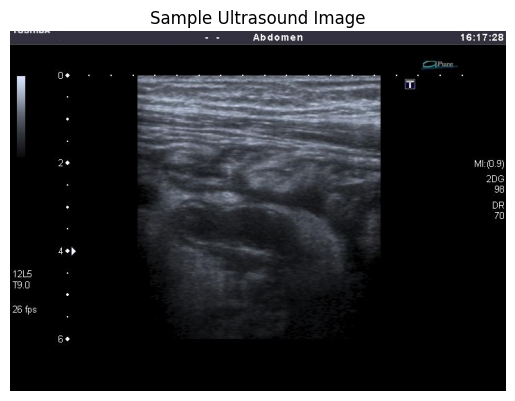

In [9]:
# Inspect data
sample_image_path = image_file_list[0]
img_bgr = cv2.imread(sample_image_path, cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Sample Ultrasound Image")
plt.axis('off');

## Preprocessing

### DeepFill (Annotation & Marker Removal and Filling)

We use DeepFill, a deep learning-based image inpainting model, to remove unwanted objects or artifacts in our ultrasound images, such as appendix bounding boxes and measurement annotations. These markings, often added by clinicians during scanning, can interfere with model training by introducing visual biases. DeepFill fills in the masked areas using information from the surrounding image, first making a rough prediction and then refining it by copying patterns from nearby regions. This allows us to produce clean, natural-looking images where the removed areas blend seamlessly with the rest of the scan.


In [19]:
deep_fill('../data/US_Pictures', 
         os.path.join('Deepfill_Temp_Dir', 'test'),
         os.path.join('Deepfill_Temp_Dir', 'test_mask'),
         os.path.join('../data', 'US_Pictures_Filled'), 
         "../DeepFill/preproc/patterns")

  0% (0 of 2097) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--



Preparing inpainting...


100% (2097 of 2097) |####################| Elapsed Time: 0:05:29 ETA:  00:00:000226

Applying DeepFill...
Generator is created!
Initialize generator with xavier type
-------------------------Loading Pretrained Model-------------------------
-------------------------Pretrained Model Loaded-------------------------
The overall number of images equals to 2096


### Cropping

We crop and pad appendix ultrasound images to isolate the main region of interest while ensuring consistent size across all images.

1. Grayscale Conversion:


    Each image is loaded and converted to grayscale to simplify processing and focus on intensity information.

2. Automatic Border Detection:


    For each side of the image, we identify where the meaningful content begins and ends by scanning for rows or columns with a sufficient proportion of bright pixels (pixels with intensity values greater than 6). We use a threshold of 6 to exclude very dark background regions that do not contain anatomical information, ensuring the crop focuses on relevant ultrasound content.


3. Cropping:

    Using the computed boundaries, we extract the central portion of the image that likely contains relevant information (e.g., the appendix), removing excess background and irrelevant regions.


4. Padding to Fixed Size:

    After cropping, we pad the image using constant padding to achieve a fixed size of 400x400 pixels. If the cropped image is smaller than the target size, black pixels are evenly added around it. If it's larger, the image is center-cropped to fit. This ensures all images have the same dimensions without distorting their content.


In [10]:
preprocess({'images':os.path.join('../data', 'US_Pictures_Filled'), 
           'target': os.path.join('../data', 'US_Pictures_Clean'),
            'padding': 'constant'})

Created target directory


100%|██████████████████████████████████████████████████████████████████| 2096/2096 [12:23<00:00,  2.82it/s]


In [ ]:
describe the deep fill and cropping 

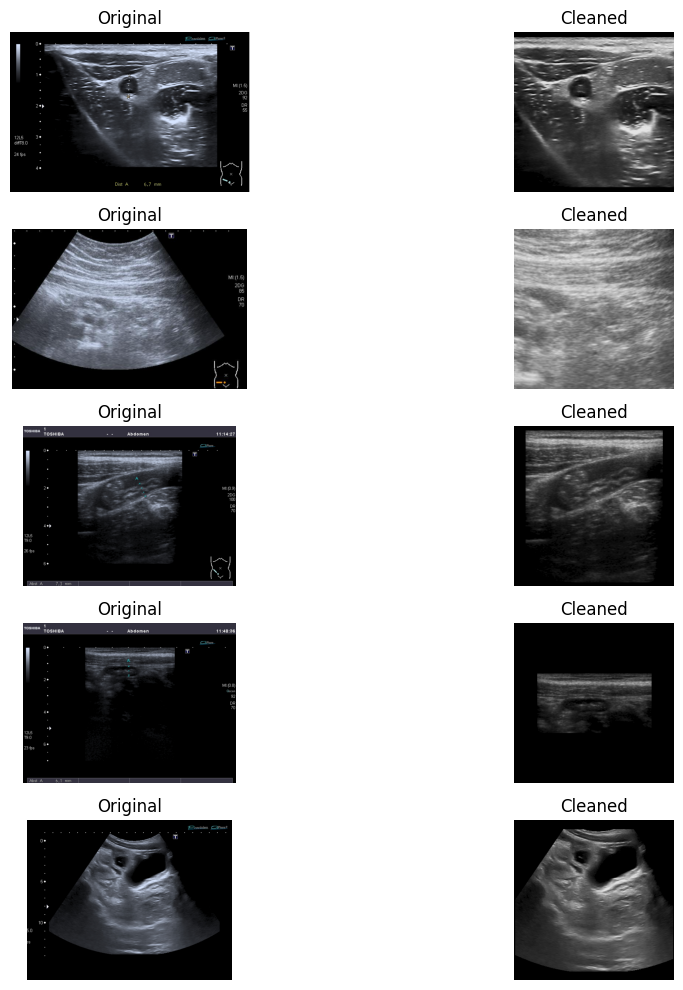

In [28]:
random.seed(89161)

original_dir = os.path.join('../data', 'US_Pictures')
cleaned_dir = os.path.join('../data', 'US_Pictures_Clean')

def normalize(name):
    return name.replace('_', ' ').lower() 

cleaned_filenames = os.listdir(cleaned_dir)
cleaned_map = {normalize(f): f for f in cleaned_filenames}

# Find matching originals
matches = []
for f in os.listdir(original_dir):
    norm_name = normalize(f)
    if norm_name in cleaned_map:
        matches.append((f, cleaned_map[norm_name]))

# Plot 5 samples of original and cleaned next to each other
sample_matches = random.sample(matches, min(5, len(matches)))

plt.figure(figsize=(12, 10))
for i, (orig_name, clean_name) in enumerate(sample_matches):
    orig_path = os.path.join(original_dir, orig_name)
    clean_path = os.path.join(cleaned_dir, clean_name)

    # Read in color and convert BGR → RGB
    orig_img = cv2.cvtColor(cv2.imread(orig_path), cv2.COLOR_BGR2RGB)
    clean_img = cv2.cvtColor(cv2.imread(clean_path), cv2.COLOR_BGR2RGB)

    plt.subplot(5, 2, i*2 + 1)
    plt.imshow(orig_img)
    plt.title(f'Original')
    plt.axis('off')

    plt.subplot(5, 2, i*2 + 2)
    plt.imshow(clean_img)
    plt.title('Cleaned')
    plt.axis('off')

plt.tight_layout()

We referenced the preprocessing techniques described by [Marcinkevics et al. (2023)](https://arxiv.org/pdf/2302.14460v2) for guidance on handling ultrasound image artifacts and ensuring consistent image formatting.


### Join Tabular and Image Data

Before further preprocessing to prevent data leakage.

### Normalization


### Data Imbalance

### Feature Scaling 